In [425]:
import requests
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import os
import tweepy
import json
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# Data wrangling
## Data Gathering
Store all downloads in folder **./data**
0. Download/Check for file archive-enhanced.csv from https://d17h27t6h515a5.cloudfront.net/topher/2017/August/59a4e958_twitter-archive-enhanced/twitter-archive-enhanced.csv
1. Download image_predictions.tsv from https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv
2. Use tweet's ids from archive-enhanced.csv to collect further data from twitter api (tweepy) and store it in tweet_json.txt

In [426]:
# 0. create folder data

dataPath = './data'
imagePredPath = './data/image-predictions.tsv'
twitterArchivePath = './data/twitter-archive-enhanced.csv'
tweetDetailsPath = './data/tweet_json.txt'

if not os.path.exists(dataPath):
    os.mkdir(dataPath)

In [427]:
# 1. Download image_predictions.tsv
if not os.path.exists(imagePredPath):
    url='https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
    r = requests.get(url)

In [428]:
#store image-predictions.tsv
if not os.path.exists(imagePredPath):
    with open(imagePredPath, 'wb') as f:
        f.write(r.content)

In [429]:
image_df = pd.read_csv(imagePredPath,sep='\t')

In [430]:
# 2. download tweet details from twitter api
df = pd.read_csv(twitterArchivePath)

In [431]:
#connect to tweepy api
consumer_key = ''
consumer_secret = ''
access_token = ''
access_token_secret = ''

In [432]:
# 3. Download details for the available ids from twitter api (tweepy)
# connnect to api
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

In [433]:
# get all relevant tweet ids
ids=list(df.tweet_id)
len(ids)

2356

In [434]:
# helper function for 'api.statuses_lookup' in order to generate tweet id lists (packages) of size 'packSize'
packSize = 100
def genIdsFromList():
    callCount = 0
    maxCount = int(len(ids)/packSize)
    while callCount <= maxCount:
        yield ids[callCount*packSize:(callCount+1)*packSize]
        callCount += 1

In [435]:
%%time

# Download the tweet details in 100 packs and store it in tweetDetailsPath='./data/tweet_json.txt'
idPack = genIdsFromList()
count =0
if not os.path.exists(tweetDetailsPath):
    with open(tweetDetailsPath, 'w') as f:
        for pack in idPack:
            count += 1
            print(count, len(pack))
            if(len(pack) == 0): 
                continue
            tweets = api.statuses_lookup(pack)
            for tweet in tweets:
                json.dump(tweet._json, f)
                f.write('\n')

Wall time: 998 µs


In [436]:
%%time

# extract line by line json files from ./data/tweet_json.txt into lists

lo_id = []
lo_retweet_count=[]
lo_favorite_count=[]
lo_created_at = []

first = True
testTweet={}
with open(tweetDetailsPath) as f:
    content = f.readlines()
    for line in content:
        jsonLine = line.strip()
        tweet = json.loads(jsonLine)
        if(first):
            testTweet = tweet
            first = False
        lo_id.append(tweet['id'])
        lo_retweet_count.append(tweet['retweet_count'])
        lo_favorite_count.append(tweet['favorite_count'])
        lo_created_at.append(tweet['created_at'])

print(len(lo_id), len(ids))

2342 2356
Wall time: 381 ms


In [437]:
# create a pd.DataFrame from the list created in the cell above 
data = {'id':lo_id, 'retweet_count':lo_retweet_count, 'favorite_count':lo_favorite_count, 'created_at':lo_created_at}
tweet_df = pd.DataFrame(data)

## Data assessing

### Assessing image predictions table

In [438]:
image_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [439]:
image_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


### Assessing tweet details stats table 

In [440]:
tweet_df.head()

,created_at,favorite_count,id,retweet_count
0,Sun Jun 18 16:57:37 +0000 2017,18504,876484053909872640,2367
1,Sat Jul 15 23:25:31 +0000 2017,20868,886366144734445568,3145
2,Wed Jun 21 19:36:23 +0000 2017,0,877611172832227328,80
3,Thu Jul 20 16:49:33 +0000 2017,21420,888078434458587136,3436
4,Sun Jul 30 15:58:51 +0000 2017,41497,891689557279858688,8496


In [441]:
tweet_df.describe()

,favorite_count,id,retweet_count
count,2342.000000,2.342000e+03,2342.000000
mean,7988.270282,7.422212e+17,2945.384714
std,12365.361259,6.832408e+16,4953.204108
min,0.000000,6.660209e+17,0.000000
25%,1378.500000,6.783509e+17,591.500000
50%,3474.500000,7.186224e+17,1374.500000
75%,9782.750000,7.986971e+17,3435.500000
max,164747.000000,8.924206e+17,83940.000000


In [442]:
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2342 entries, 0 to 2341
Data columns (total 4 columns):
created_at        2342 non-null object
favorite_count    2342 non-null int64
id                2342 non-null int64
retweet_count     2342 non-null int64
dtypes: int64(3), object(1)
memory usage: 73.3+ KB


### Assessing main tweets table 

In [443]:
df.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1492,692828166163931137,NaN,NaN,2016-01-28 21:54:41 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This pupper just descended from heaven. 12/10 ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/692828166...,12,10,None,None,None,pupper,None
352,831315979191906304,NaN,NaN,2017-02-14 01:35:49 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",I couldn't make it to the #WKCDogShow BUT I ha...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/831315979...,13,10,None,None,None,pupper,None
1022,746542875601690625,NaN,NaN,2016-06-25 03:17:46 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",Here's a golden floofer helping with the groce...,NaN,NaN,NaN,https://vine.co/v/5uZYwqmuDeT,11,10,None,None,floofer,None,None
1254,710658690886586372,NaN,NaN,2016-03-18 02:46:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a brigade of puppers. All look very pre...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/710658690...,80,80,None,None,None,None,None
1116,732585889486888962,NaN,NaN,2016-05-17 14:57:41 +0000,"<a href=""http://twitter.com/download/iphone"" r...","When your teacher agreed on 10,000 RTs and no ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/732585889...,10,10,None,None,None,None,None


In [444]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [445]:
df.duplicated().any()

False

#### Quality
`tweet image predictions` image_df
- make all labels same format lower case

`tweet details` tweet_df
- transform created at to date time type
- extract weekday from created at and store as category
- rename column **id** to **tweet_id**

`main tweets` df
- timestamp to date time type
- remove records with rating_denominator unequal 10
- remove rating_denominator col since it has only one the 
entry '10'
- replace all not set names and to short names with a default name.
- convert in_reply_to_status_id/ in_reply_to_user_id/retweeted_status_id/retweeted_user_id to int
- extract @recipient from text into column recipient
- convert source to categorical type (iPhone, web, vine, TwitterDeck)
- remove retweeted /replay rows
- remove retweeted /replay cols after the step before

#### Tidiness
`tweet image predictions` image_df
- p1 p2 p3 is one variable (melt to a new table with new vars p, breed, conf, isdog)

`main tweets` df
- doggo/floofer/pupper/puppo melt to one var of dtype="category"

## Data cleaning


### Cleaning images data

In [446]:
image_df_clean = image_df.copy()

#### Define
1. p1 p2 p3 is one variable (melt to a new table with new vars p, breed, conf, isdog)


#### Code

In [447]:
image_df_clean.head(2)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True


In [448]:
#1. p1 p2 p3 is one variable (melt to a new table with new vars p, breed, conf, isdog)
tmp1=pd.melt(image_df_clean, id_vars=['tweet_id'], value_vars=['p1','p2','p3'], var_name='p', value_name='breed')
tmp2=pd.melt(image_df_clean, id_vars=['tweet_id'], value_vars=['p1_conf','p2_conf','p3_conf'], var_name='p', value_name='conf')
tmp3=pd.melt(image_df_clean, id_vars=['tweet_id'], value_vars=['p1_dog','p2_dog','p3_dog'], var_name='p', value_name='dog')
tmp2.p=tmp2.p.str.split('_').str[0]
tmp3.p=tmp3.p.str.split('_').str[0]
melted_df = tmp1.merge(tmp2, on=['tweet_id','p']).merge(tmp3, on=['tweet_id','p'])
image_df_clean = image_df_clean.merge(melted_df, on='tweet_id', how='left')

In [449]:
image_df_clean.drop(['p1','p2','p3','p1_conf','p2_conf','p3_conf','p1_dog','p2_dog','p3_dog'], axis=1, inplace=True)

#### Test

In [450]:
firtsId = image_df_clean[image_df_clean.tweet_id == 666020888022790149]
assert len(firtsId) == 3
assert len(image_df_clean) == len(image_df)*3
assert image_df_clean.tweet_id.unique().sort() == image_df.tweet_id.unique().sort()
firtsId

,tweet_id,jpg_url,img_num,p,breed,conf,dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,p1,Welsh_springer_spaniel,0.465074,True
1,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,p2,collie,0.156665,True
2,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,p3,Shetland_sheepdog,0.061428,True


#### Define
- devide breed labels into single columns with same format lower case

#### Code

In [451]:
#devide breed labels into single columns with same format lower case
image_df_clean.breed = image_df_clean.breed.str.lower()

#### Test

In [452]:
print(image_df_clean.breed.str[0].head())
image_df_clean.head(2)

0    w
1    c
2    s
3    r
4    m
Name: breed, dtype: object


,tweet_id,jpg_url,img_num,p,breed,conf,dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,p1,welsh_springer_spaniel,0.465074,True
1,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,p2,collie,0.156665,True


### Cleaning tweet detail stats data

In [453]:
tweet_df_clean = tweet_df.copy()

#### Define
- transform created at to datetime type
- extract weekday from created at and store as category
- rename column id to tweet_id

#### Code

In [454]:
#transofrm created at to datetime type
tweet_df_clean['date'] = pd.to_datetime(tweet_df_clean.created_at)

In [455]:
#extract weekday from created at and store as category
tweet_df_clean['weekday'] = tweet_df_clean.created_at.str.split(' ', expand=True)[0].astype('category')

In [456]:
#remove not needed column
tweet_df_clean.drop('created_at', axis=1, inplace=True)

In [457]:
#rename column id to tweet_id
tweet_df_clean.rename(columns={'id':'tweet_id'}, inplace=True)

#### Test

In [458]:
tweet_df_clean.head(1)

,favorite_count,tweet_id,retweet_count,date,weekday
0,18504,876484053909872640,2367,2017-06-18 16:57:37,Sun


In [459]:
tweet_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2342 entries, 0 to 2341
Data columns (total 5 columns):
favorite_count    2342 non-null int64
tweet_id          2342 non-null int64
retweet_count     2342 non-null int64
date              2342 non-null datetime64[ns]
weekday           2342 non-null category
dtypes: category(1), datetime64[ns](1), int64(3)
memory usage: 75.9 KB


### Clening core tweet data

In [460]:
df_clean = df.copy()

#### Define

- delete rows with outlier rating_numerator > 20

- timestamp to date time type

- retweet status timestamp to date time type

- remove records with rating_denominator unequal 10

- remove rating_denominator col since it contains only the number 10

- replace all not set names and to short names with a default name.

- convert in_reply_to_status_id/ in_reply_to_user_id/retweeted_status_id/retweeted_user_id to int

- extract @recipient from text into column recipient

- convert source to categorical type (iPhone, web, vine, TwitterDeck)

- remove rows that are  retweeted or replay  

- remove empty cols of retweeted  or replay after the step before


#### Code

In [461]:
#delete rows with outlier rating_numerator > 20
df_clean.drop(df_clean[df_clean.rating_numerator > 20].index, inplace=True)

In [462]:
# timestamp to date time type
# retweet status timestamp to date time type
df_clean.timestamp = pd.to_datetime(df_clean.timestamp)
df_clean.retweeted_status_timestamp=pd.to_datetime(df_clean.retweeted_status_timestamp)

In [463]:
# remove records with rating_denominator unequal 10
df_clean.drop((df_clean.rating_denominator != 10), inplace=True)

In [464]:
#remove rating_denominator col
df_clean.drop('rating_denominator', axis=1, inplace=True)

In [465]:
#replace all not set names and to short names with a default name.
df_clean.name = df_clean.name.map(lambda x: 'None' if len(x) < 2 else x)

In [466]:
df_clean[['in_reply_to_status_id','in_reply_to_user_id','retweeted_status_id','retweeted_status_user_id']]=df_clean[['in_reply_to_status_id','in_reply_to_user_id','retweeted_status_id','retweeted_status_user_id']].astype(object)

In [467]:
#extract @receipient from text into column receipient
df_clean['receipient'] = df_clean.text.str.extract(r'@(\w*)')

C:\Users\Dima\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  from ipykernel import kernelapp as app


In [468]:
#convert source to categorical type (iPhone, web, vine, TwitterDeck)
def mapToCategory(x):
    return {
        '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>':'iPhone',
       '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>':'Web Client',
       '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>':'Vine',
       '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>': 'TweetDeck'
    }[x]
df_clean.source = df_clean.source.map(mapToCategory).astype('category')

In [469]:
#remove rows that are  retweeted or replay  
interaction_df_clean = df_clean[['tweet_id','in_reply_to_status_id','in_reply_to_user_id','retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp']].copy()
df_clean.drop(interaction_df_clean.dropna(thresh=2).index, inplace=True)

In [470]:
#remove empty cols of retweeted  or replay after the step before
df_clean.drop(['in_reply_to_status_id','in_reply_to_user_id','retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp'],axis=1, inplace=True)

#### Test

In [471]:
assert df_clean.name.map(lambda x: len(x) < 2).any() == False
assert (df_clean.rating_numerator > 20).any() == False
df_clean.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,name,doggo,floofer,pupper,puppo,receipient
2,891815181378084864,2017-07-31 00:18:03,iPhone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,Archie,None,None,None,None,NaN
3,891689557279858688,2017-07-30 15:58:51,iPhone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,Darla,None,None,None,None,NaN
4,891327558926688256,2017-07-29 16:00:24,iPhone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,Franklin,None,None,None,None,NaN
5,891087950875897856,2017-07-29 00:08:17,iPhone,Here we have a majestic great white breaching ...,https://twitter.com/dog_rates/status/891087950...,13,None,None,None,None,None,NaN
6,890971913173991426,2017-07-28 16:27:12,iPhone,Meet Jax. He enjoys ice cream so much he gets ...,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,Jax,None,None,None,None,NaN


#### Define

- doggo/floofer/pupper/puppo melt to one var of dtype="category"

#### Code

In [472]:
#doggo/floofer/pupper/puppo melt to one var of dtype="category"
df_clean['stage'] = (df_clean.doggo + df_clean.floofer+ df_clean.pupper+df_clean.puppo).str.replace('None',' ')
df_clean.drop(labels=['doggo','floofer','pupper','puppo'], axis=1, inplace=True)
df_clean.drop(df_clean[df_clean.stage.str.len()>10].index, axis=0, inplace=True)

In [473]:
df_clean.stage = df_clean.stage.str.strip().map(lambda x: 'None' if len(x) == 0 else x)

In [474]:
df_clean.stage = df_clean.stage.astype('category')

#### Test

In [475]:
assert len(df_clean.stage.unique()) == 5
df_clean.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,name,receipient,stage
2,891815181378084864,2017-07-31 00:18:03,iPhone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,Archie,NaN,None
3,891689557279858688,2017-07-30 15:58:51,iPhone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,Darla,NaN,None
4,891327558926688256,2017-07-29 16:00:24,iPhone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,Franklin,NaN,None
5,891087950875897856,2017-07-29 00:08:17,iPhone,Here we have a majestic great white breaching ...,https://twitter.com/dog_rates/status/891087950...,13,None,NaN,None
6,890971913173991426,2017-07-28 16:27:12,iPhone,Meet Jax. He enjoys ice cream so much he gets ...,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,Jax,NaN,None


## Store Cleaned Data

In [476]:
# df_clean.to_csv('df_clean.csv')
# tweet_df_clean.to_csv('tweet_df_clean.csv')
# image_df_clean.to_csv('image_df_clean.csv')
twitter_archive_master = df_clean.merge(tweet_df_clean, on='tweet_id').merge(image_df_clean, on='tweet_id')
twitter_archive_master.to_csv('twitter_archive_master.csv', index=False)

# Analysis

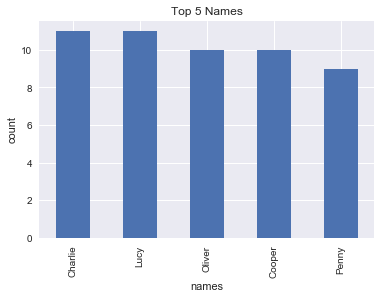

In [477]:
# most favorit names 
ax = df_clean.name.value_counts()[1:6].plot(kind='bar')

plt.title('Top 5 Names')
plt.xlabel('names')
plt.ylabel('count')

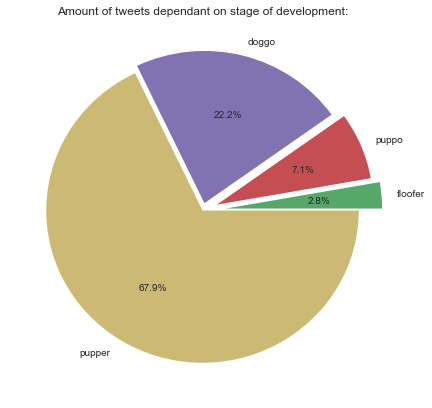

In [478]:
# most favorit stage in development 
plt.figure(figsize=(7,7))
tmp_df = (df_clean[df_clean.stage != ['None']]).groupby('stage').tweet_id.count().sort_values()
ax = tmp_df.plot(kind='pie', autopct=(lambda pct: '{:.1f}%'.format(pct) if pct != 0 else ''), explode=(np.linspace(0.2,0,5)), label='')
ax.set_title("Amount of tweets dependant on stage of development:")

count    1058.000000
mean       10.349716
std         2.261647
min         1.000000
25%        10.000000
50%        11.000000
75%        12.000000
max        14.000000
Name: rating_numerator, dtype: float64
count     4.000000
mean     12.000000
std       1.414214
min      10.000000
25%      11.500000
50%      12.500000
75%      13.000000
max      13.000000
Name: rating_numerator, dtype: float64
count    468.000000
mean      11.032051
std        2.103591
min        0.000000
25%       10.000000
50%       11.000000
75%       12.000000
max       14.000000
Name: rating_numerator, dtype: float64
count    536.000000
mean      10.667910
std        1.963636
min        2.000000
25%       10.000000
50%       11.000000
75%       12.000000
max       14.000000
Name: rating_numerator, dtype: float64


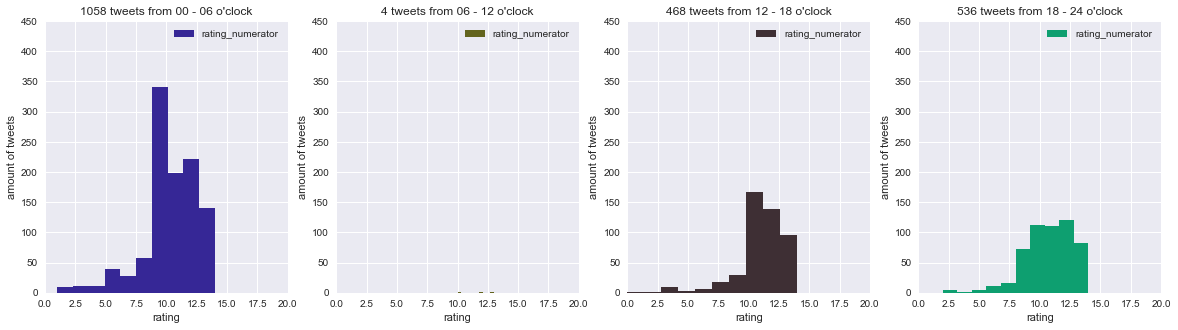

In [479]:
# ratings vs amounts based on time of the day 
def timePlot(fromTime, toTime, ax):
        timeBasedRatings = df_clean[df_clean.timestamp.dt.strftime('%H:%M:%S').between('{}:00:00'.format(fromTime),'{}:00:00'.format(toTime))].rating_numerator
        print(timeBasedRatings.describe())
        timeBasedRatings.plot(kind='hist',style='*', color = np.random.rand(3,)*0.9, legend=True, figsize=(20,5))
        ax.set_xlim(0, 20)
        ax.set_ylim(0, 450)
        ax.set_xlabel('rating')
        ax.set_ylabel('amount of tweets')
        ax.set_title('{} tweets from {} - {} o\'clock'.format(timeBasedRatings.count(),fromTime, toTime))
        

times=['00','06','12','18','24']

for i in range(len(times)-1):   
    ax = plt.subplot(1, 4, i+1)
    timePlot(times[i],times[i+1], ax)

In [480]:
# top rated breed 
main_and_image_df = df_clean.set_index('tweet_id').join(image_df_clean.set_index('tweet_id'))

In [491]:
from IPython.display import Image, display
def showDogsAndRatings(query, show=False, limit = 3):
    query_rated_df = main_and_image_df.query(query)
    query_rated_df.breed.value_counts()[0:5].plot(kind="bar", figsize=(20,5))
    if( not show): return
    i = 1
    for index, row in query_rated_df.sort_values('rating_numerator', ascending = False).iterrows():
        display(Image(row.jpg_url, width=150),  '{} {}'.format(row.breed, row.rating_numerator))
        if(limit <= i):
            break
        i +=1

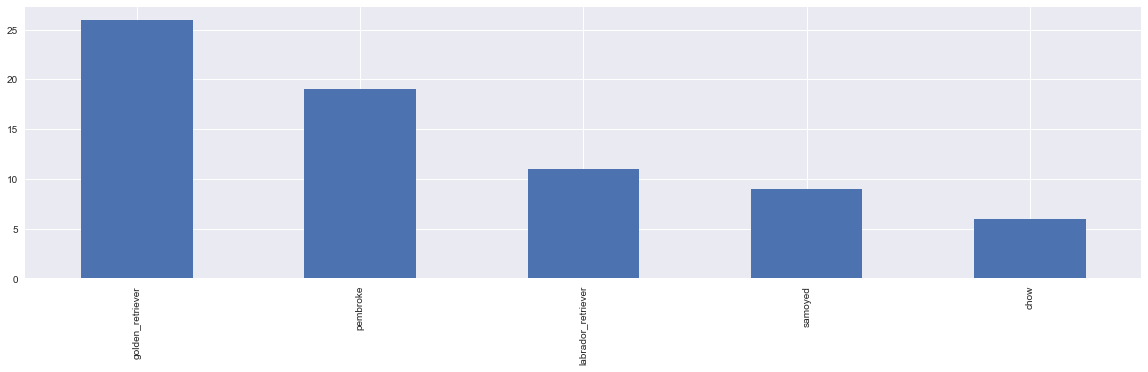

In [492]:
# dogs with highest ratings
showDogsAndRatings('rating_numerator > 12 and dog == True and p == "p1" and conf > 0.5')

In [483]:
tmp_df = main_and_image_df.join(tweet_df_clean.set_index('tweet_id'))

In [484]:
tmp_df.query('p == "p1" or p ==  "NaN"').groupby('weekday').rating_numerator.count()

weekday
Fri    273
Mon    321
Sat    245
Sun    247
Thu    277
Tue    285
Wed    292
Name: rating_numerator, dtype: int64

In [485]:
tmp_df.groupby('weekday')[['retweet_count','rating_numerator']].corr()

retweet_count  rating_numerator
weekday                                                  
Fri     retweet_count          1.000000          0.203346
        rating_numerator       0.203346          1.000000
Mon     retweet_count          1.000000          0.283093
        rating_numerator       0.283093          1.000000
Sat     retweet_count          1.000000          0.231391
        rating_numerator       0.231391          1.000000
Sun     retweet_count          1.000000          0.331009
        rating_numerator       0.331009          1.000000
Thu     retweet_count          1.000000          0.376980
        rating_numerator       0.376980          1.000000
Tue     retweet_count          1.000000          0.407343
        rating_numerator       0.407343          1.000000
Wed     retweet_count          1.000000          0.383083
        rating_numerator       0.383083          1.000000